In [2]:
from google.colab import files
uploaded = files.upload()



Saving credit card fraud detection.zip to credit card fraud detection.zip


In [5]:
import zipfile

# Unzip the file
with zipfile.ZipFile("credit card fraud detection.zip", "r") as zip_ref:
    zip_ref.extractall("./")  # Extract in the current directory

# Check extracted files
import os
print(os.listdir("./"))  # Look for 'creditcard.csv'




['.config', 'creditcard.csv', 'credit card fraud detection.zip', 'sample_data']


In [6]:
import pandas as pd

df = pd.read_csv("creditcard.csv")  # Ensure filename matches
print(df.head())  # Check if data is loaded correctly


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))
df["Time"] = scaler.fit_transform(df["Time"].values.reshape(-1, 1))


In [8]:
from imblearn.over_sampling import SMOTE

X = df.drop("Class", axis=1)
y = df["Class"]

smote = SMOTE(sampling_strategy=0.2, random_state=42)  # Increase fraud cases to 20%
X_resampled, y_resampled = smote.fit_resample(X, y)


In [9]:
df["Rolling_Mean_Amount"] = df["Amount"].rolling(window=10, min_periods=1).mean()


In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98     56966
           1       0.97      0.87      0.92     11270

    accuracy                           0.97     68236
   macro avg       0.97      0.93      0.95     68236
weighted avg       0.97      0.97      0.97     68236

AUC-ROC Score: 0.9333741407918377


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=50, random_state=42)  # Reduce from 100 to 50
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)


In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=50, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=100)
xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:52:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [16]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_rf))  # For Random Forest
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_rf))

# If using XGBoost
print(classification_report(y_test, y_pred_xgb))
print("AUC-ROC Score:", roc_auc_score(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56966
           1       1.00      1.00      1.00     11270

    accuracy                           1.00     68236
   macro avg       1.00      1.00      1.00     68236
weighted avg       1.00      1.00      1.00     68236

AUC-ROC Score: 0.9987143578942043
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     56966
           1       0.98      1.00      0.99     11270

    accuracy                           1.00     68236
   macro avg       0.99      1.00      0.99     68236
weighted avg       1.00      1.00      1.00     68236

AUC-ROC Score: 0.9974985078818945


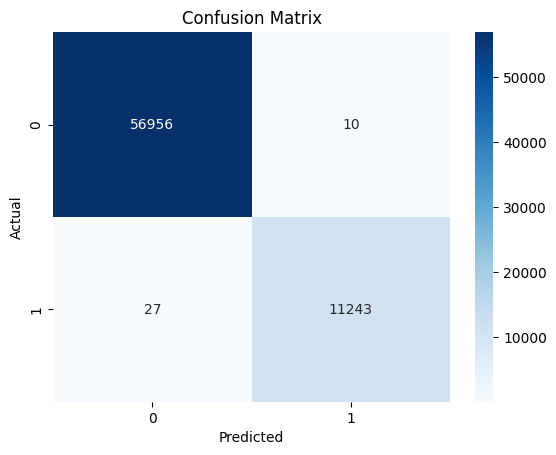

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_rf)  # Use y_pred_xgb if using XGBoost
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()



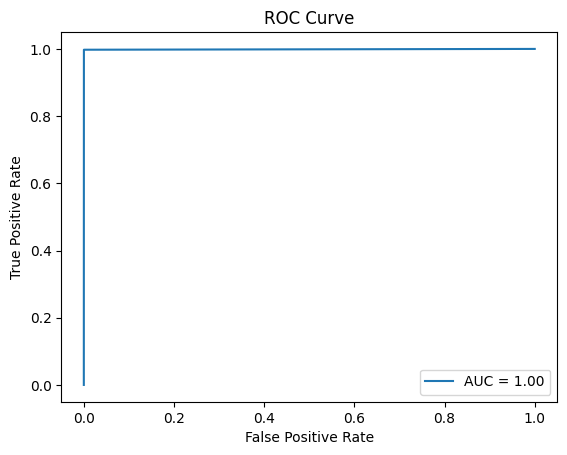

In [18]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_pred_rf)  # Use y_pred_xgb for XGBoost
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [19]:
import pickle

with open("fraud_detection_model.pkl", "wb") as f:
    pickle.dump(rf, f)  # Change `rf` to `xgb` if using XGBoost


In [20]:
import joblib

joblib.dump(rf, "fraud_detection_model.joblib")  # Change `rf` to `xgb` if using XGBoost


['fraud_detection_model.joblib']